# Generative Forecast Autoregressively

* This notebook loads a pre-trained time series model to make forecast with minimal testing data. 

* Model takes previous lags to autoregressively make forecast. Last forecast is appended to initial data.
    * This can be repeted with indefinately but forecasts are less accurate as steps increase.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from models.transformer import GPTTimeSeries

import os
import random
import numpy as np
import pandas as pd
import math
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['axes.grid'] = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'USING DEVICE: {device}')

USING DEVICE: cuda


# Dataset

In [2]:
# Airline Passgeners
#df_full = pd.read_csv('data/airline_passengers/airline-passengers.csv')

# Panama Electricity Load Forecasting
df_full = pd.read_csv('data/panama_electricity_load_forecasting/train.csv')


df_full.head()

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,03-01-2015 01:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,03-01-2015 02:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,03-01-2015 03:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,03-01-2015 04:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,03-01-2015 05:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


In [3]:
# Airline Passgeners
#df_full['Month'] = pd.to_datetime(df_full['Month'])

# Panama Electricity Load Forecasting
df_full['datetime'] = pd.to_datetime(df_full['datetime'], dayfirst=True)

df_full.head()

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


In [4]:
# # Airline Passgeners
#df_full.set_index('Month', inplace=True)

# Panama Electricity Load Forecasting
df_full.set_index('datetime', inplace=True)

df_full.tail()

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
2019-12-31 19:00:00,1301.6065,26.635645,0.018421,0.013165,13.184052,25.135645,0.018048,0.064240,3.086798,23.620020,0.016697,0.073425,3.865351,22,1,0
2019-12-31 20:00:00,1250.9634,26.495935,0.018162,0.014713,13.443892,24.769373,0.017781,0.058838,3.659980,23.284998,0.016606,0.064362,4.171572,22,1,0
2019-12-31 21:00:00,1193.6802,26.354456,0.017980,0.013836,13.442195,24.479456,0.017606,0.038086,3.769294,23.041956,0.016492,0.054260,4.045283,22,1,0
2019-12-31 22:00:00,1130.4575,26.166895,0.017965,0.018486,13.420656,24.112207,0.017393,0.020386,3.872397,22.862207,0.016401,0.055557,3.843736,22,1,0
2019-12-31 23:00:00,1084.4737,25.976373,0.018072,0.023315,13.749788,23.663873,0.017156,0.019531,4.165276,22.726373,0.016302,0.061371,3.793209,22,1,0


<Axes: xlabel='datetime'>

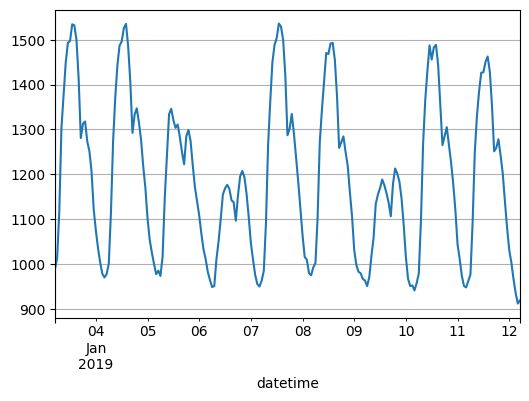

In [5]:
# Airline Passgeners
#df_full.plot()

# Panama Electricity Load Forecasting
df_full.loc['2019-01-03 05:00:00':'2019-01-12 05:00:00', 'nat_demand'].plot()

# Standart Scaler
* Exercise: Try without scaler, see if learning works!

<Axes: xlabel='datetime'>

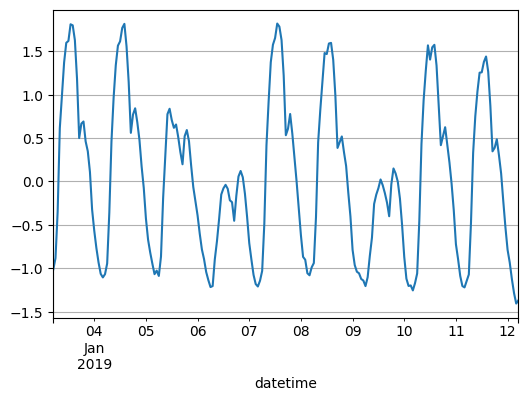

In [6]:
feature_scaler = StandardScaler()

# Airline Passgeners
#df_full['Passengers'] = scaler.fit_transform(df_full['Passengers'].values.reshape(-1, 1))

# Panama Electricity Load Forecasting
df_full[df_full.columns] = feature_scaler.fit_transform(df_full[df_full.columns])

# Airline Passgeners
#df_full.plot()

# Panama Electricity Load Forecasting
df_full.loc['2019-01-03 05:00:00':'2019-01-12 05:00:00', 'nat_demand'].plot()

# Time series data shape: 
Unbatched: $(S, F)$

* $S:$ Sequence Length
* $F:$ Number of Features

Batched: $(B, S, F)$
* $B:$ Batch Size

In [7]:
df_full.shape

(43775, 16)

# Load Saved Checkpoint

In [8]:
checkpoint = torch.load('./saved_models/GPTTimeSeries_Autoregressive.pt')
checkpoint.keys()

dict_keys(['model_state_dict', 'optimizer_state_dict', 'hyperparameters', 'scaler_state_dict'])

# Load Saved (Pre-trained) Model

In [9]:
hyperparameters = checkpoint['hyperparameters']

print('Model hyperparameters is loaded with:')

for k, v in hyperparameters.items():
    print(f'{k:<25} {v}')
print()

Model hyperparameters is loaded with:
window_size               100
input_features_size       16
date_input_features_size  3
date_features_dim         64
hidden_features_size      192
output_features_size      16
num_heads                 4
ff_dim                    1024
num_decoder_layers        12
emb_dropout_prob          0.1
attn_dropout_prob         0.1
ff_dropout_prob           0.1
attn_use_bias             False
ff_use_bias               False
output_features_bias      False
batch_size                128
split_ratio               0.8
learning_rate             0.001
num_epochs                60
use_amp                   True



In [10]:
model = GPTTimeSeries(
    input_features_size=hyperparameters['input_features_size'],
    date_input_features_size=hyperparameters['date_input_features_size'],
    date_features_dim=hyperparameters['date_features_dim'],
    features_dim=hyperparameters['hidden_features_size'],
    output_features_size=hyperparameters['output_features_size'],
    num_heads=hyperparameters['num_heads'],
    ff_dim=hyperparameters['ff_dim'],
    num_decoder_layers=hyperparameters['num_decoder_layers'],
    emb_dropout_prob=hyperparameters['emb_dropout_prob'],
    attn_dropout_prob=hyperparameters['attn_dropout_prob'],
    ff_dropout_prob=hyperparameters['ff_dropout_prob'],
    attn_use_bias=hyperparameters['attn_use_bias'],
    ff_use_bias=hyperparameters['ff_use_bias'],
    output_features_bias=hyperparameters['output_features_bias'],
)

In [11]:
model.to(device)
model.load_state_dict(checkpoint['model_state_dict'], strict=True)

<All keys matched successfully>

# Generative Forecast

In [12]:
@torch.no_grad()
def generative_forecast(model, data, timestamps, num_steps, lag_window_size, use_amp, device):
    model.eval()
    
    predictions = []
    time_indexes = []
    
    # covnert to tensor
    # data.shape: (lags, features)
    lags = torch.tensor(data[-lag_window_size:, :], dtype=torch.float32, device=device)
    
    # artificially add batch dimension
    # (we are not using the dataloader here!)
    # data.shape: (1, lags, features)
    lags = lags.unsqueeze(0)

    # Datetime indexes 
    #timestamps = df_full.index 
    # Delta time: calculate the time difference between two samples 
    delta_time = timestamps[1] - timestamps[0]
    # Get last timestamp
    current_timestamp = timestamps[-1]

    def generate_date_tensor(_timestamp, _lags, _device):
        _timestamp = _timestamp[-lag_window_size:]
        return torch.tensor([_timestamp.month, _timestamp.day, _timestamp.hour], dtype=torch.float32, device=_device).permute(1, 0)
    
    # single step
    for idx in tqdm(range(num_steps)):

        # get the last lag steps
        lags = lags[:, -lag_window_size:, :]
        #print(lags)

        # date
        date = generate_date_tensor(timestamps, lag_window_size, device).unsqueeze(0)

        with torch.autocast(device_type=device, dtype=torch.float16, enabled=use_amp):
            forecast_pred = model(lags, date)
        
        # (batch, forecast, output_features_size)-> (1, window_size-1, output_features_size)
        # TAKE THE LAST PREDICTION STEP AS FORECAST!
        predictions.append(forecast_pred[0][-1].cpu().numpy())

        # update current timestamp
        current_timestamp = current_timestamp + delta_time
        time_indexes.append(current_timestamp)
        
        # append last forecast to the end
        # TAKE THE LAST PREDICTION STEP AS FORECAST!
        lags = torch.cat((lags, forecast_pred[:, -1:, :].detach()), dim=1)
        
        # next timestamp
        timestamps = timestamps + delta_time

    return predictions, time_indexes

In [13]:
# should be min of original model
REQUEST_WINDOW_SIZE = 200 * 2 # * 2 is added for convenience
# temp dataframe for generative prediction input
df_temp = df_full[-REQUEST_WINDOW_SIZE:]

pred_generative, time_indexes_generative = generative_forecast(
    model=model, 
    data=df_temp.values,
    timestamps=df_temp.index,
    num_steps=300, 
    lag_window_size=hyperparameters['window_size'], 
    use_amp=hyperparameters['use_amp'], 
    device=device
)

pred_generative_array = np.array(pred_generative)

generative_results_dict = {}

# loop ove features
for feature_id, feature_key in enumerate(df_temp.columns):
    generative_results_dict[feature_key] = pred_generative_array[:, feature_id]
        
df_generative = pd.DataFrame(data=generative_results_dict, index=time_indexes_generative)

# REVERSE THE PREPROCESSING FOR ORIGINAL RANGE
df_generative[df_generative.columns] = feature_scaler.inverse_transform(df_generative[df_generative.columns])    

100%|████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 114.26it/s]


<Axes: >

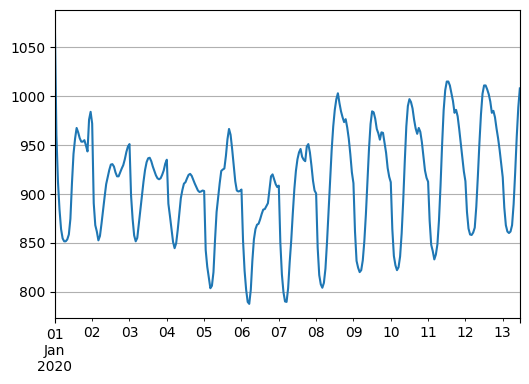

In [14]:
selected_feature = 'nat_demand'
df_generative[selected_feature].plot()